<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S15/DataPreparation_S15A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the drive

In [1]:
# I have the images in 2 folders. One is background and the other image is the foreground image. 
# First I have to read the images. 

from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)


Mounted at /content/drive


In [2]:
import sys

%rm -rf /content/eva
!git clone https://github.com/raguram/eva.git

sys.path.append("/content/eva/cnn-lib/src/cnnlib")
sys.path.append("/content/eva/cnn-lib/src/")
print("Added required libraries to system path")

Cloning into 'eva'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 603 (delta 130), reused 188 (delta 55), pack-reused 279
Receiving objects: 100% (603/603), 30.57 MiB | 22.00 MiB/s, done.
Resolving deltas: 100% (254/254), done.
Added required libraries to system path


## Copy the foreground and background images from drive

In [3]:
%mkdir /content/data
%cp -r /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/bg_images /content/data
%cp -r /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/fg_images /content/data

mkdir: cannot create directory ‘/content/data’: File exists


## Read the foreground and background images

Stats of foreground

Number of images: 109
Min width, Max width, Min Height, Max height: 13, 310, 63, 356
Average width and height 184.90825688073394, 220.3302752293578
Stats of background

Number of images: 110
Min width, Max width, Min Height, Max height: 100, 342, 100, 300
Average width and height 231.84545454545454, 196.3


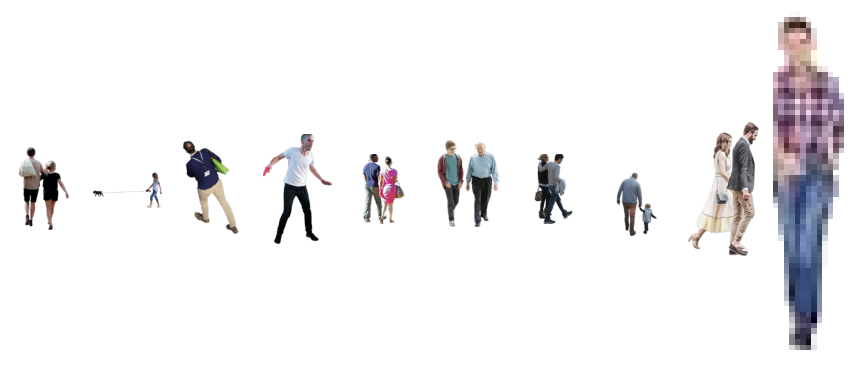

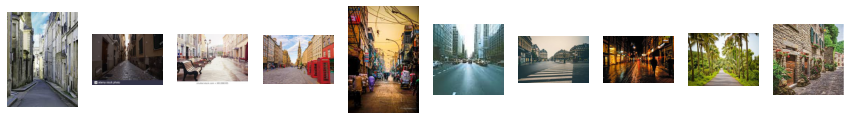

In [4]:
import cv2
from cv2 import imread
from os import listdir
from google.colab.patches import cv2_imshow
from PIL import Image, ImageOps
import ImageUtils

fg_images = [Image.open(join("/content/data/fg_images/", f)) for f in listdir("/content/data/fg_images/") if f != ".DS_Store"] 
bg_images = [Image.open(join("/content/data/bg_images/", f)) for f in listdir("/content/data/bg_images/") if f != ".DS_Store"]

ImageUtils.get_stats(fg_images, "foreground")
ImageUtils.get_stats(bg_images, "background")

ImageUtils.show_images(fg_images[0:10], cols=10)
ImageUtils.show_images(bg_images[0:10], cols=10)

## Utility Functions

In [0]:
def remove_outliers(images, min_width, min_height): 

  out_images = []
  for img in images: 
    if(img.size[0] >= min_width and img.size[1] >= min_height): 
        out_images.append(img)

  print(f"Filtered outliers. Number of input images: {len(images)}. Number of output images {len(out_images)}")
  return out_images

def writeLabels(bg_file_name, fg_file_name, fg_bg_files, fg_bg_mask_files, labelFile): 
  for i in range(len(fg_bg_files)): 
    labelFile.write(f"{bg_file_name}\t{fg_file_name}\t{fg_bg_files[i]}\t{fg_bg_mask_files[i]}\n")


## Preprocess the images 

*   Resize the background images to 224, 224
*   Thumbnail the foreground images to 150, 150
*   Remove the outliers in fg_images
*   Mirror the foreground images 
*   Create masks for the foreground images 





Filtered outliers. Number of input images: 109. Number of output images 104
Stats of foreground

Number of images: 208
Min width, Max width, Min Height, Max height: 44, 150, 78, 150
Average width and height 117.0576923076923, 138.85576923076923
Stats of background

Number of images: 110
Min width, Max width, Min Height, Max height: 224, 224, 224, 224
Average width and height 224, 224


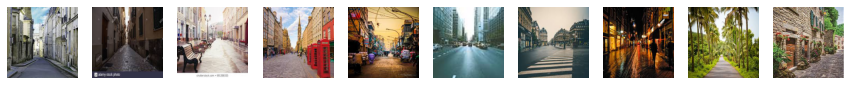

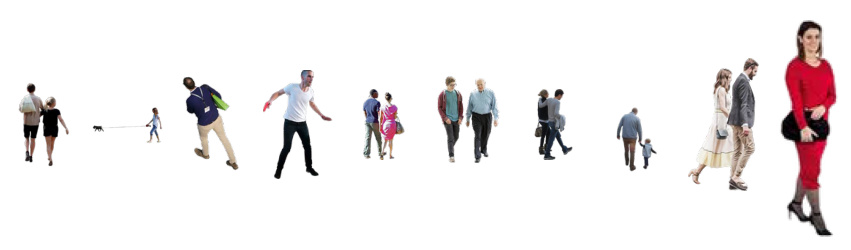

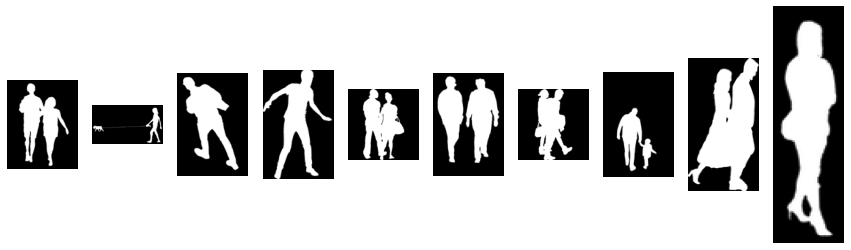

In [6]:
import PIL

bg_images = [img.resize((224, 224)) for img in bg_images]

for img in fg_images:
  img.thumbnail((150, 150), PIL.Image.ANTIALIAS) 

fg_images = remove_outliers(fg_images, 40, 50)

fg_flipped_images = [ImageOps.mirror(img) for img in fg_images]
fg_images = fg_images + fg_flipped_images
fg_mask_images = [img.split()[-1] for img in fg_images]

ImageUtils.show_images(bg_images[0:10], cols=10)
ImageUtils.show_images(fg_images[0:10], cols=10)
ImageUtils.show_images(fg_mask_images[0:10], cols=10)

ImageUtils.get_stats(fg_images, "foreground")
ImageUtils.get_stats(bg_images, "background")

## Sample fg_bg images with masks

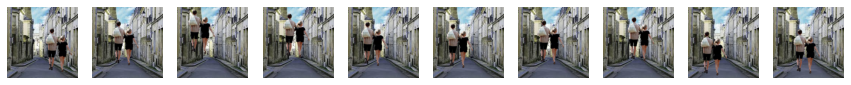

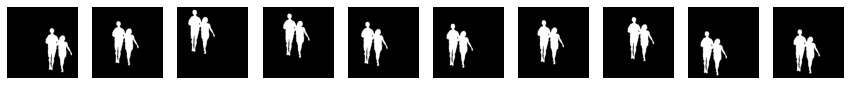

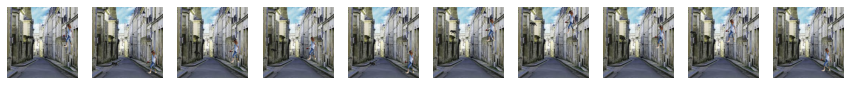

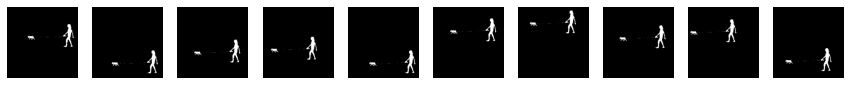

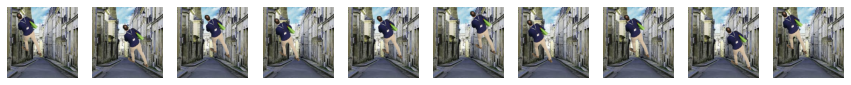

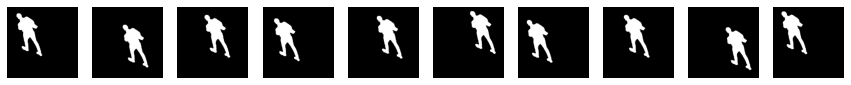

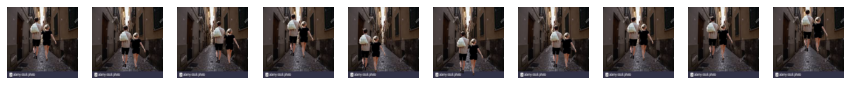

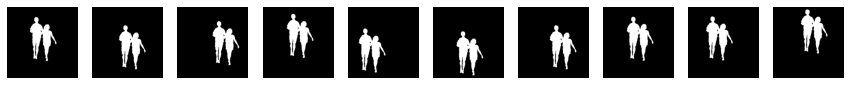

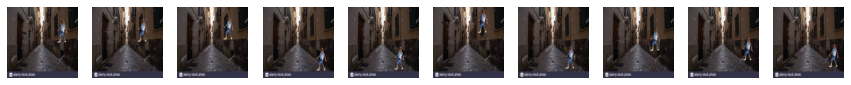

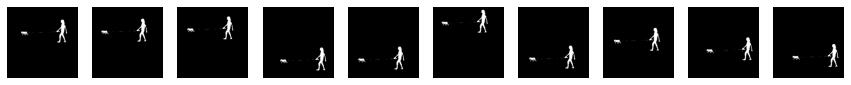

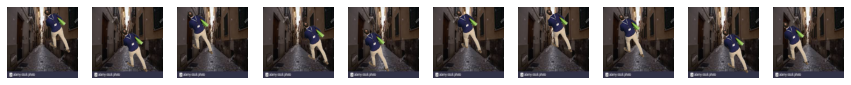

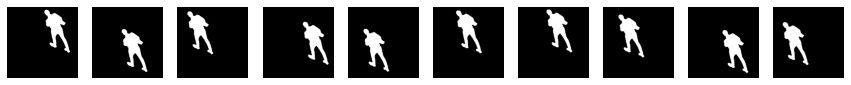

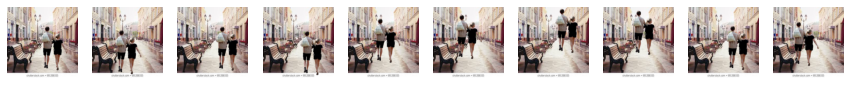

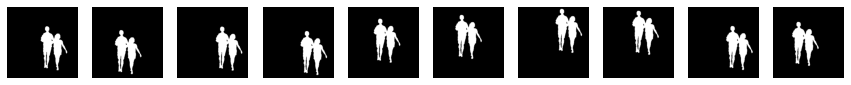

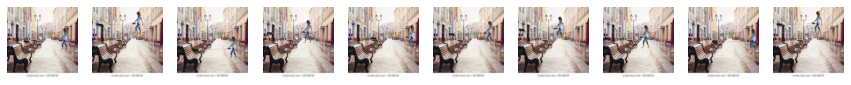

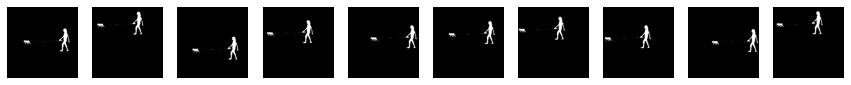

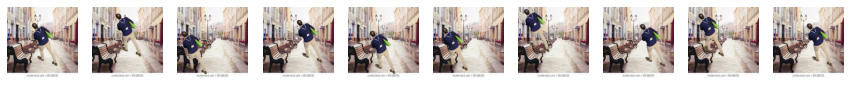

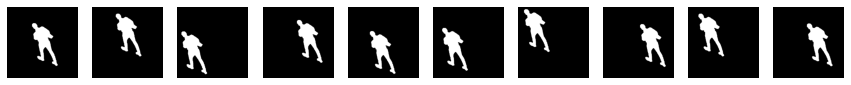

In [7]:
for bg_idx, bg in enumerate(bg_images[:3]): 
  for fg_idx, fg in enumerate(fg_images[:3]):
    fg_bg_images, fg_bg_masks = ImageUtils.paste_fg_on_bg(bg, fg, fg_mask_images[fg_idx], 10)
    ImageUtils.show_images(fg_bg_images, cols=10)
    ImageUtils.show_images(fg_bg_masks, cols=10)

## Create the dataset 

In [9]:
from datetime import datetime
import ImageDao
from zipfile import ZipFile

zip = ZipFile("data.zip", "a")

bg_image_files = ImageDao.ZipFileImagePersister(zip, "bg_images")(bg_images)
fg_image_files = ImageDao.ZipFileImagePersister(zip, "fg_images", "png")(fg_images)

labelsFile = open("labels.txt", "w")

# Generate images and add to the zip. 
fg_bg_writer = ImageDao.ZipFileImagePersister(zip, "fg_bg")
fg_bg_mask_writer = ImageDao.ZipFileImagePersister(zip, "fg_bg_mask")

count=0
for bg_idx, bg in enumerate(bg_images): 
  startTime = datetime.now()
  for fg_idx, fg in enumerate(fg_images):    
    
    fg_bg_images, fg_bg_masks = ImageUtils.paste_fg_on_bg(bg, fg, fg_mask_images[fg_idx], 20)
    names = [f"Image_{bg_idx}_{fg_idx}_{i}.JPEG" for i in range(count, count + len(fg_bg_images))]
    
    fg_bg_image_files = fg_bg_writer(fg_bg_images, names)
    fg_bg_mask_files = fg_bg_mask_writer(fg_bg_masks, names)

    writeLabels(bg_image_files[bg_idx], fg_image_files[fg_idx], fg_bg_image_files, fg_bg_mask_files, labelsFile)
    count += len(fg_bg_image_files)
  print(f"Processed bg: {bg_idx + 1} image. Total image count: {count}. Time Taken: {datetime.now() - startTime}")
    
labelsFile.close()
zip.close()
print(count)

Processed bg: 1 image. Total image count: 4160. Time Taken: 0:00:14.475916
Processed bg: 2 image. Total image count: 8320. Time Taken: 0:00:13.450509
Processed bg: 3 image. Total image count: 12480. Time Taken: 0:00:14.419608
Processed bg: 4 image. Total image count: 16640. Time Taken: 0:00:14.932069
Processed bg: 5 image. Total image count: 20800. Time Taken: 0:00:14.998238
Processed bg: 6 image. Total image count: 24960. Time Taken: 0:00:13.205399
Processed bg: 7 image. Total image count: 29120. Time Taken: 0:00:13.710524
Processed bg: 8 image. Total image count: 33280. Time Taken: 0:00:15.455108
Processed bg: 9 image. Total image count: 37440. Time Taken: 0:00:15.136361
Processed bg: 10 image. Total image count: 41600. Time Taken: 0:00:16.145741
Processed bg: 11 image. Total image count: 45760. Time Taken: 0:00:13.720475
Processed bg: 12 image. Total image count: 49920. Time Taken: 0:00:13.692237
Processed bg: 13 image. Total image count: 54080. Time Taken: 0:00:12.988601
Processed 

## Copy the zip file to the drive 

In [0]:
%cp -r /content/data.zip /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/
%cp /content/labels.txt /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/